# Прогнозирование заказов такси

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Содержание
1. Знакомство с данными
2. Анализ данных
3. Обучение моделей
4. Общий вывод

## Знакомство с данными

Для начала познакомимся с предоставленными данными заказчика.

In [26]:
#!pip install catboost

In [27]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
rcParams['figure.figsize'] = (20,10)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [29]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [30]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Видим, что у нас всего два признака:

* `datetime`- предположительно время сбора статистики;
* `num_orders` - количество заказов в данный момент времени

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, упорядочены ли наши данные или нет. Сделаем проверку на монотонность:

In [32]:
if data.index.is_monotonic:
    print('Время упорядочено')
else:
    print('Время неупорядочено')

Время упорядочено


Данные, предоставленные заказчиком, имеют упорядоченный вид. Теперь построим график, чтобы провести первичный анализ данных:

In [33]:
def plot(df: pd.DataFrame, title = None):
    df.plot(ax = plt.gca(), grid = True)
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Количество заказов');

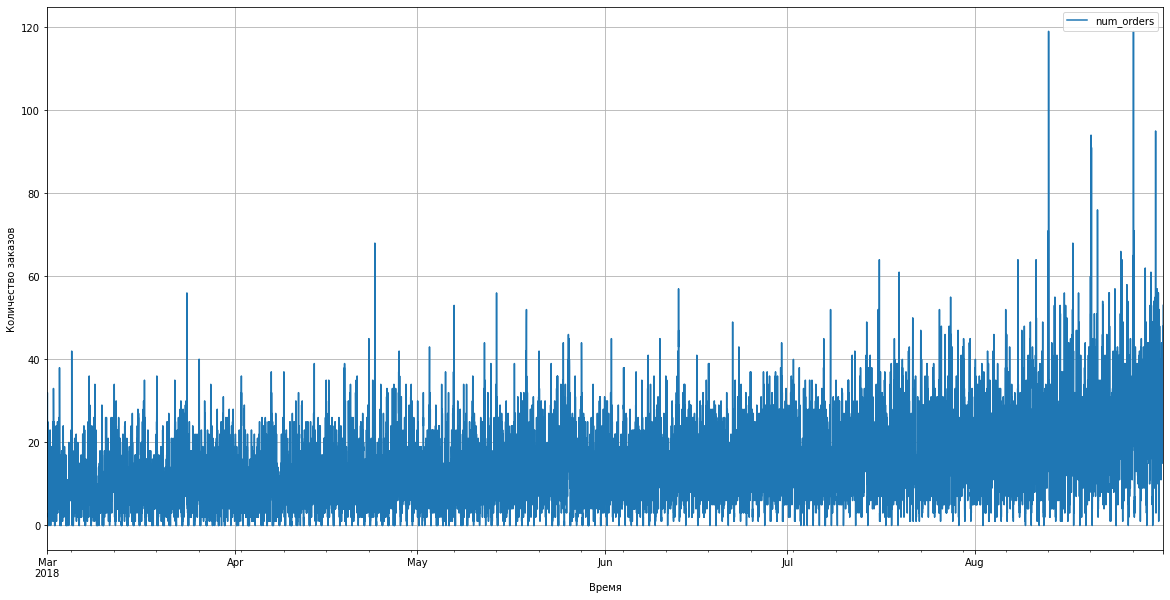

In [34]:
plot(data)

Данных, а точнее частота сбора информации оказалось слишком много, чтобы можно было сформулировать выводы по данным.

## Вывод

Познакомились с предоставленными заказчиком данными. Сделали проверку на монотонность, построили график по полученным данным. Оказалось, по такой частоте трудно сформулировать выводы. Необходимо провести ресемплирование данных.

## Анализ данных

По такому графику трудно, что сказать насчет тренда и сезонности. Поэтому для начала сделаем ресемплирование (в 1 час):

In [35]:
data = data.resample('1H').sum()

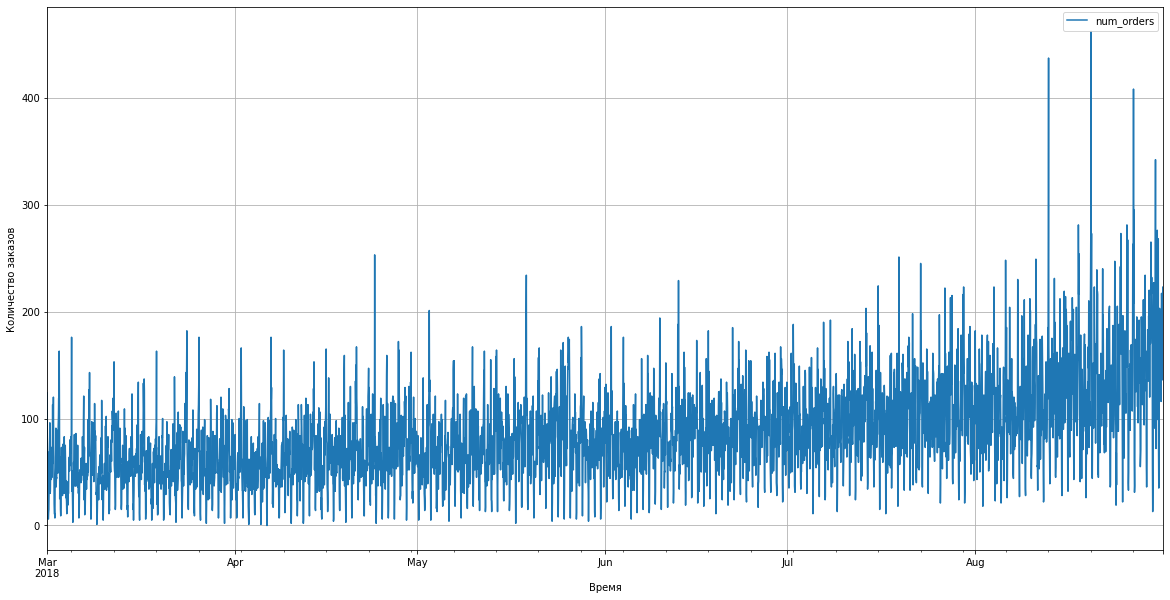

In [36]:
plot(data)

Посмотрим на результаты скользящего среднего и скользящего отклонения.

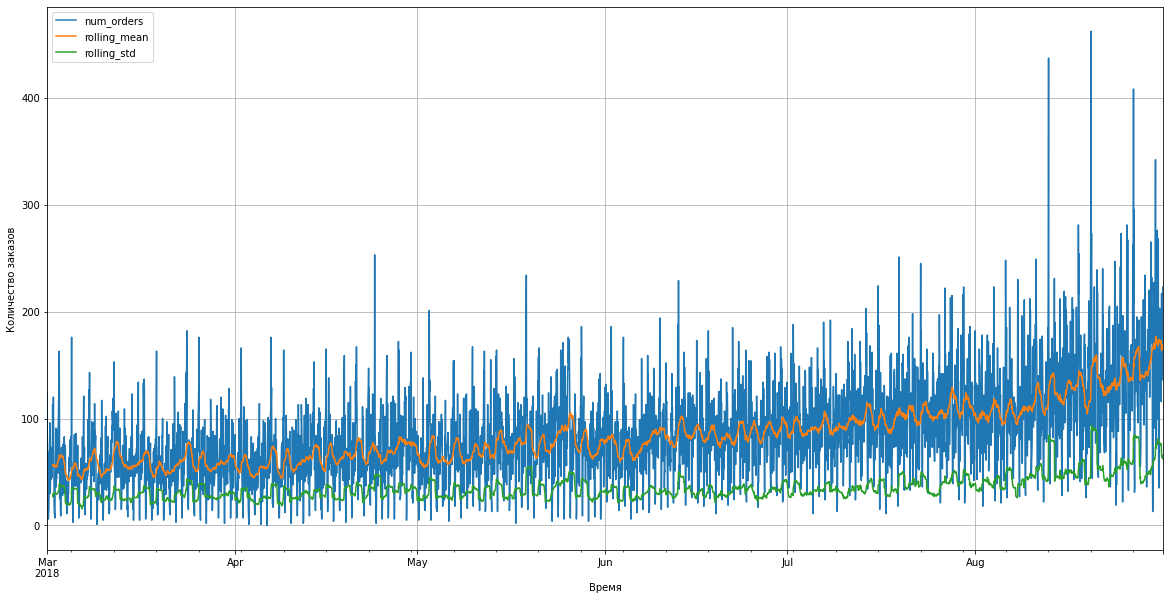

In [37]:
data_to_plot = data.copy()
data_to_plot['rolling_mean'] = data_to_plot.rolling(24).mean()
data_to_plot['rolling_std'] = data_to_plot.num_orders.rolling(24).std()
plot(data_to_plot)

Видим, что среднее потребление в сутки (взяли окно в 24 часа) плавно растет. Посмотрим на временной ряд в декомпозиции: разложим наш ряд на тред, сезонность и остаток и посторим их графики

In [38]:
decomposed_data = seasonal_decompose(data)

Теперь построим графики

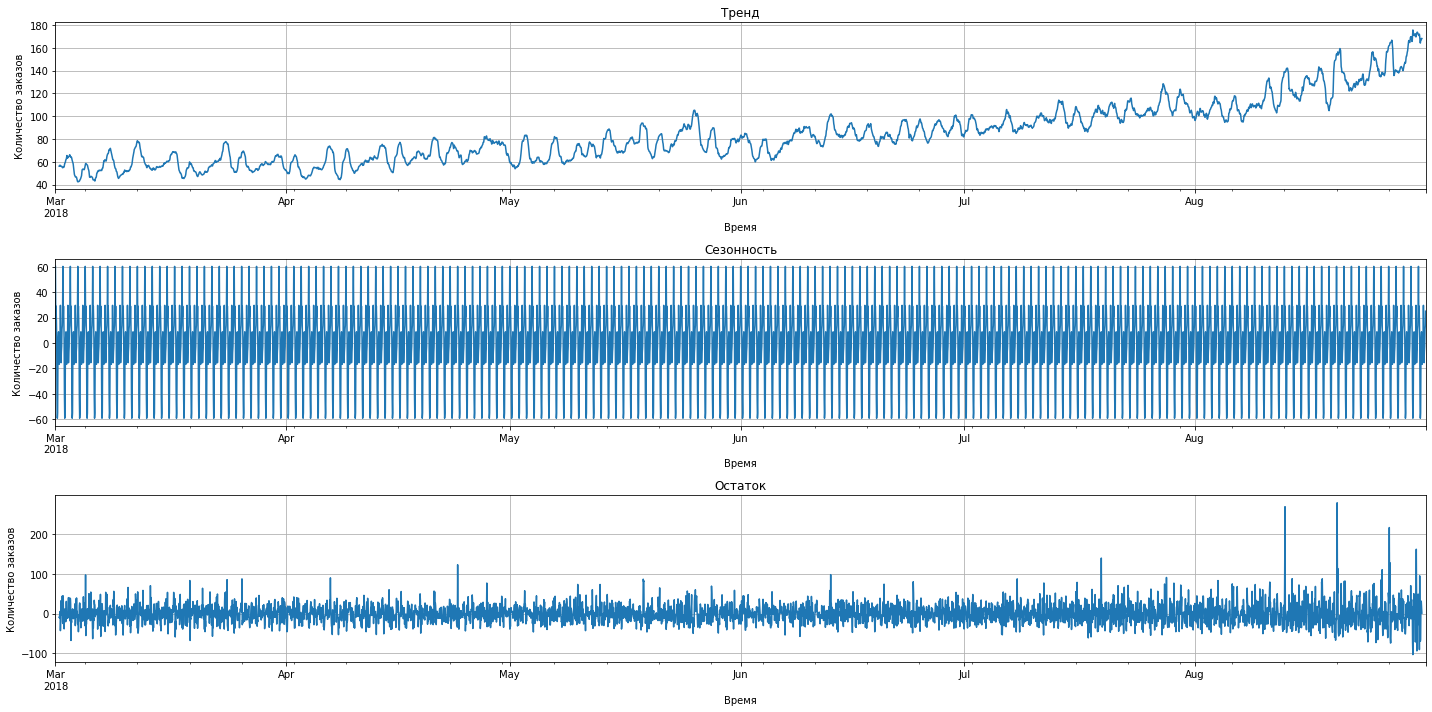

In [39]:
plt.subplot(311)
plot(decomposed_data.trend, 'Тренд')
plt.subplot(312)
plot(decomposed_data.seasonal, 'Сезонность')
plt.subplot(313)
plot(decomposed_data.resid, 'Остаток')
plt.tight_layout()

По этим графикам видим следующее: к началу лета спрос на такси растет по сравнению с остальными временами года. Предположим, что это связано с сезоном отпусков и многие возвращаются или едут в *аэропорты с помощью такси. 

*данные от заказчика представлена в виде количества заказов такси в аэропортах.

Видим, что сезонность наблюдается меньше месяца. Посмотрим на этот график поближе:

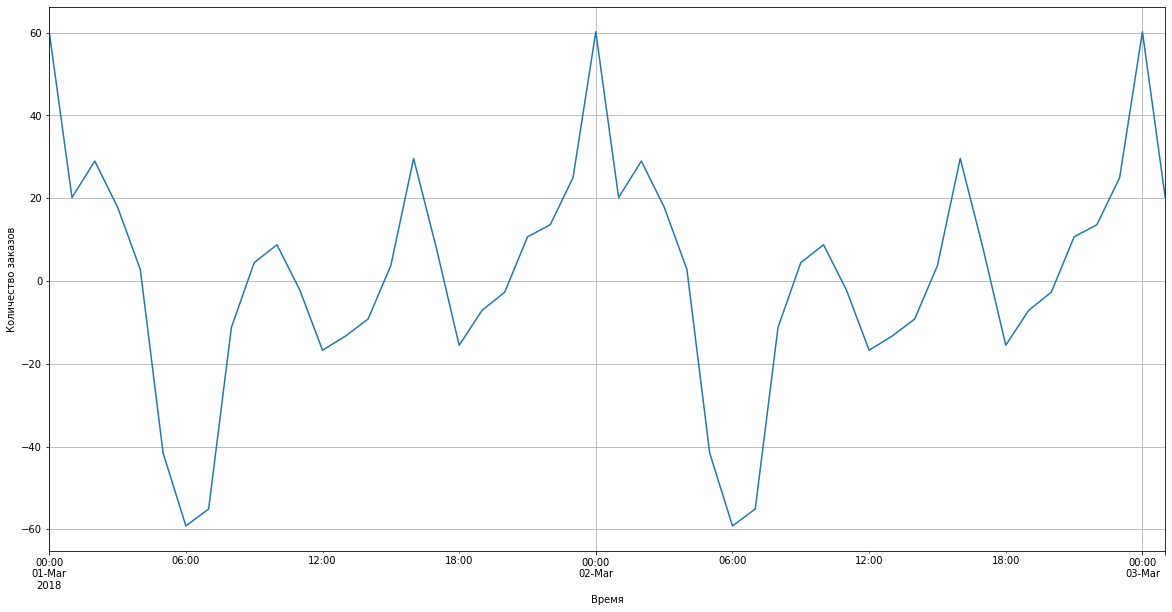

In [40]:
# 50 - количество часов, которые мы срезали чтобы увеличить масштаб для сезонности
# так как ресемплирование сделали почасовое
plot(decomposed_data.seasonal[:50])

Здесь мы ведеим следующую картину: 

Люди практически не заказаывают такси ранним утром. Пик заказов наступает ближе к полуночи и в послеобеденное время (с полудня до 18 часов вечера).

Прежде чем обучать модели, сделаем проверку модели на стационарность. По графику видели, что среднее количество заказов растет к лету. Но это не дает понимание того, является ли данный временной ряд стационарным? Для этого сделаем проверку с помощью метода Дикки-Фуллера:

In [41]:
test = adfuller(data.num_orders)
print('p-value: ', test[1])
if test[1] > 0.05:
    print('Ряд не стационарен')
else:
    print('Ряд стационарен')

p-value:  0.028940051402612802
Ряд стационарен


Таким образом убедились в том, что представленный ряд - стационарен.

## Вывод
В процессе анализа данных увидели следующие закономерности:
1. К лету среднее число заказов плавно растет;
2. Сезонность: ежедневно к утру заказов практически нет, однако ближе к ночи количество заказов растет;
3. Определили, что ряд стационарен.

Теперь перейдем к обучению моделей.

## Обучение моделей

Для начала определимся, с помощью каикх моделей будем делать прогноз.

Преддложили следующие варианты:
1. Прогнозирование без обучения:
    * все значения прогнозируются одним числом - константой (в нашем случае - среднее значение);
    * текущее значение предсказывается предыдущим значением.
2. Прогнозирование с обучением:
    * Линейная регрессия;
    * Дерево решений;
    * Случайный лес;
    * CatBoostRegressor;
    * LightGBMRegressor.

Для прогнозирования с обучением необходимо сформировать признаки:
* День недели;
* Час;
* Сформировать временные лаги;
* Добавить скользящее среднее.

In [42]:
class learn_model():
    # инициализация всех параметров-атрибутов объектов класса
    # формируем фичи
    # формируем выборки: тестовая и обучаяющая
    # из этих выборок делаем признаки
    # заранее глобально внутри класса инициализировал скоринг - так проще

    def __init__(self, data:pd.DataFrame, max_lag: int, rolling:int):
        
        self.df = data.copy()
        self.df['dayofweek'] = self.df.index.dayofweek
        self.df['hour'] = self.df.index.hour

        max_lag = max_lag
        rolling = rolling

        for i in range(1, max_lag+1):
            self.df['lag_'+str(i)] = self.df.num_orders.shift(i)
        self.df['rolling_mean'] = self.df.num_orders.shift().rolling(rolling).mean()

        self.train, self.test = train_test_split(self.df, 
                                                 shuffle = False, 
                                                 test_size=0.1)

        self.train = self.train.dropna()

        self.y_train = self.train.num_orders
        self.y_test = self.test.num_orders

        self.X_train = self.train.drop('num_orders', axis = 1)
        self.X_test = self.test.drop('num_orders', axis = 1)

        self.scoring = 'neg_root_mean_squared_error'

        self.test_list_res = []
        self.test_index = []

    # методы класса для работы с пронозом без обучения
    # прогноз константой
    def constant(self):
        pred_mean = np.ones(self.y_test.shape) * self.y_train.mean()
        self.test_list_res.append(mean_squared_error(self.y_test, 
                                                     pred_mean, 
                                                     squared = False))
        self.test_index.append('Константное значение')
        print(f'''Значение метрики RMSE при прогнозе константным значением:
         {mean_squared_error(self.y_test, pred_mean, squared = False)}''')

    # проноз предыдущим
    def previous_value(self):
        pred_prev = self.y_test.shift()
        pred_prev.iloc[0] = self.y_train.iloc[-1]
        self.test_list_res.append(mean_squared_error(self.y_test, 
                                                     pred_prev, 
                                                     squared = False))
        self.test_index.append('Предыдущее значение')
        print(f'''Значение метрики RMSE при прогнозе предыдущим значением: 
         {mean_squared_error(self.y_test, pred_prev, squared = False)}''')

    # статические методы для работы с атрибутами и внутри методов объекта класса
    # выбор признака в зависимости от модели  
    @staticmethod
    def take_params(model_type: str):
        if 'RandomForest' in model_type:
            params = {'max_depth': range(10, 81, 10),
                  'n_estimators': range(1, 7, 2)}

        elif 'DecisionTree' in model_type:
            params = {'max_depth': range(10,81,10)}

        elif 'CatBoostRegressor' in model_type:
            params = {'iterations': range(100, 201, 100),
                  'depth': range(10, 13, 2)}
        else:
            params = {'max_depth': range(10, 16, 5),
                 'n_estimators': range(10, 81, 10),
                 'num_leaves': range(20, 81, 20)}
                
        return params

    # статический метод - формирование кросс-валидации для временного ряда
    @staticmethod
    def tscv(self):
        test_size = int(0.1*len(self.df))
        return TimeSeriesSplit(n_splits = 7, test_size=test_size)

    # cтатический метод - грубый поиск
    # инициализация и обучение
    @staticmethod
    def grid_model(self, model, params):

        self.model = GridSearchCV(model, 
                                  params, 
                                  cv = self.tscv(self), 
                                  n_jobs = -1, 
                                  scoring = self.scoring,
                                  verbose = 10)
        
        self.model.fit(self.X_train, self.y_train)

        print(f'''Значение метрики RMSE на обучающей выборке для
         {model.__class__.__name__}: {self.model.best_score_}\n''')
        return self.model

    # Статический метод: построение итогового графика моделирования
    @staticmethod
    def plot(self, model, prediction):
        plt.plot(self.y_test.index, 
                 self.y_test, 
                 self.y_test.index, 
                 prediction, 'r-')
        
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.grid(True)
        plt.legend(['Реальное значение', 'Прогноз от модели'])
        plt.title(f'''Сравнение целевого признака и прогноза, полученного с помощью 
        {model.__class__.__name__}''')

    # обучение линейной регрессией
    def lr_model(self):
        model = LinearRegression()
        
        print(f'''Значение метрики RMSE на обучающей выборке для 
        {model}:{cross_val_score(model,self.X_train, 
                                 self.y_train, 
                                 cv = self.tscv(self), 
                                 n_jobs = -1, 
                                 scoring = self.scoring).mean()}\n''')
        return model

    # обучение деревом решений
    def dt_model(self):
        model = DecisionTreeRegressor(random_state = 54321)
        self.grid = self.grid_model(self, model, 
                                    self.take_params(model.__class__.__name__))
        return self.grid.best_estimator_
        
    # обучение случайным лесом
    def rf_model(self):
        model = RandomForestRegressor(random_state = 54321)
        self.grid = self.grid_model(self, model, 
                                    self.take_params(model.__class__.__name__))
        
        return self.grid.best_estimator_

    # обучение CatBoostR
    def catboost(self):
        model = CatBoostRegressor(learning_rate=.1,  thread_count=-1 ,verbose = 10)
        self.grid = self.grid_model(self, model, 
                                    self.take_params(model.__class__.__name__))
        
        return self.grid.best_estimator_

    # обучение LightGBMR
    def light_r(self):
        model = LGBMRegressor(learning_rate = .1, 
                              random_state = 54321, 
                              verbose = 10,
                             n_jobs = -1)
        self.grid = self.grid_model(self, model, 
                                    self.take_params(model.__class__.__name__))
        
        return self.grid.best_estimator_
    
    # проведение финального тестирования
    def res(self, model):
        model.fit(self.X_train, self.y_train)
        prediction = model.predict(self.X_test)

        self.plot(self, model, prediction)

        self.test_list_res.append(mean_squared_error(self.y_test, 
                                                     prediction, 
                                                     squared=False))
        self.test_index.append(model.__class__.__name__)
        
        print(f'''Итоговое значение RMSE на тестовой выборке: 
        {mean_squared_error(self.y_test, prediction, squared=False)}\n''')

    # Для создания итоговой таблицы
    def print(self):
        return pd.DataFrame({'Результаты финального тестирования': self.test_list_res}, index = self.test_index)

In [43]:
test = learn_model(data, 4, 36)

**Прогнозирование с помощью константной значения**

In [44]:
test.constant()

Значение метрики RMSE при прогнозе константным значением:
         84.59364304690212


**Прогнозирование с помощью предыдущего значения**

In [45]:
test.previous_value()

Значение метрики RMSE при прогнозе предыдущим значением: 
         58.856486242815066


**Прогнозирование с помощью Линейной регрессии**

Значение метрики RMSE на обучающей выборке для 
        LinearRegression():-32.37037554604715

Итоговое значение RMSE на тестовой выборке: 
        50.85293264965054



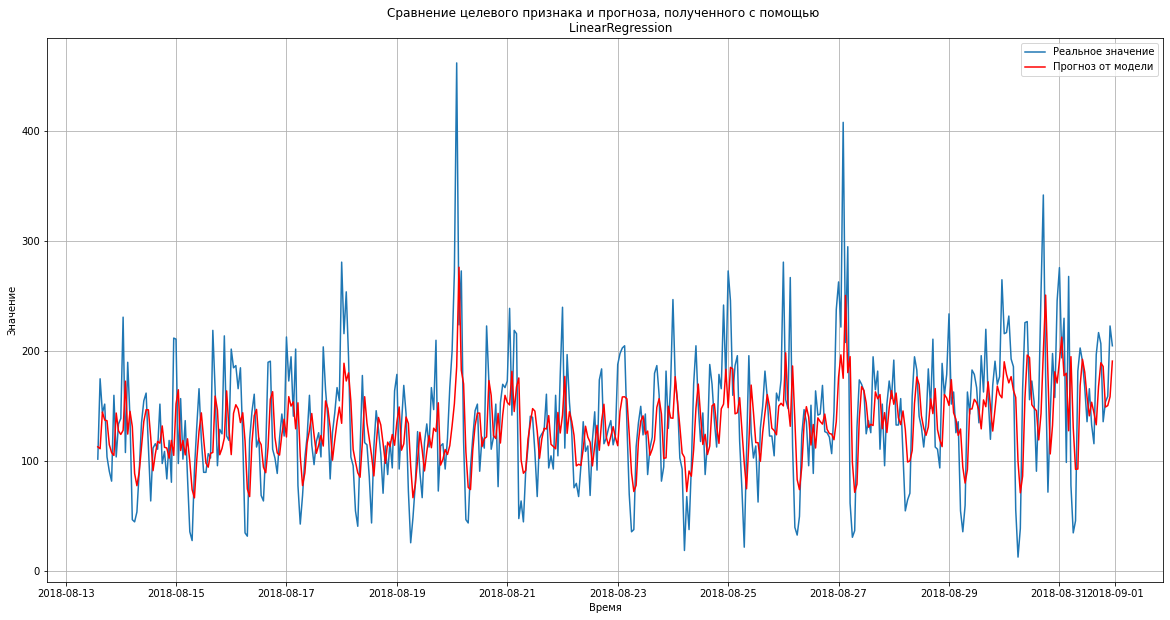

In [46]:
test.res(test.lr_model())

**Прогнозирование с помощью решающего дерева**

Fitting 7 folds for each of 8 candidates, totalling 56 fits
Значение метрики RMSE на обучающей выборке для
         DecisionTreeRegressor: -30.700524960572437

Итоговое значение RMSE на тестовой выборке: 
        54.14729071557424



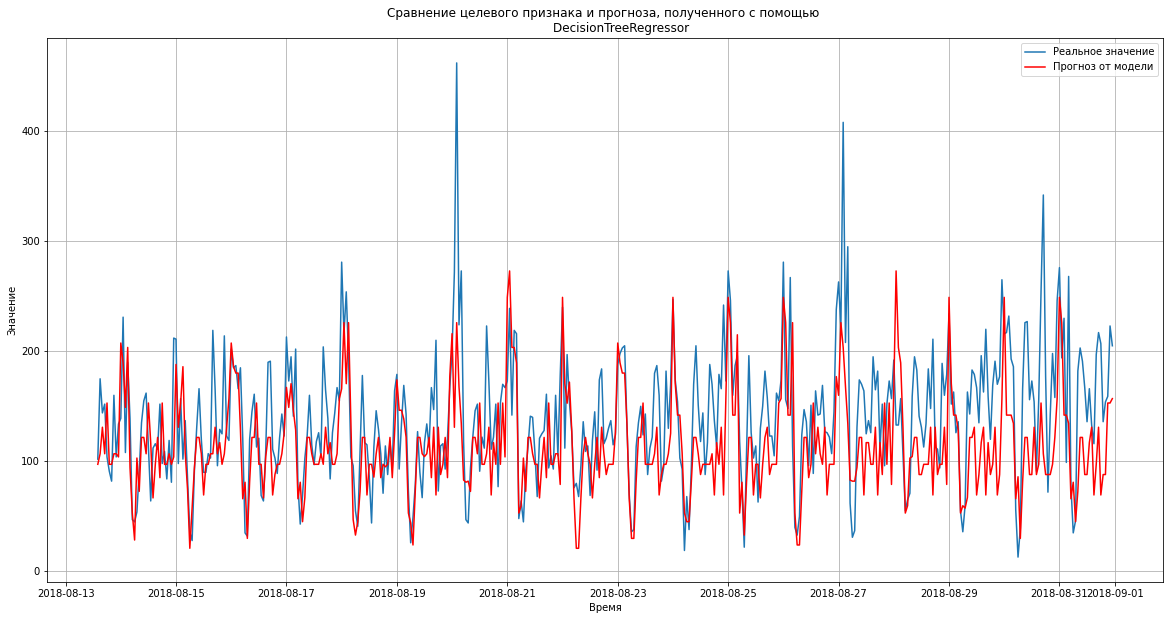

In [47]:
test.res(test.dt_model())

**Прогнозирование с помощью случайного леса**

Fitting 7 folds for each of 24 candidates, totalling 168 fits
Значение метрики RMSE на обучающей выборке для
         RandomForestRegressor: -27.761095084670142

Итоговое значение RMSE на тестовой выборке: 
        52.73991728471577



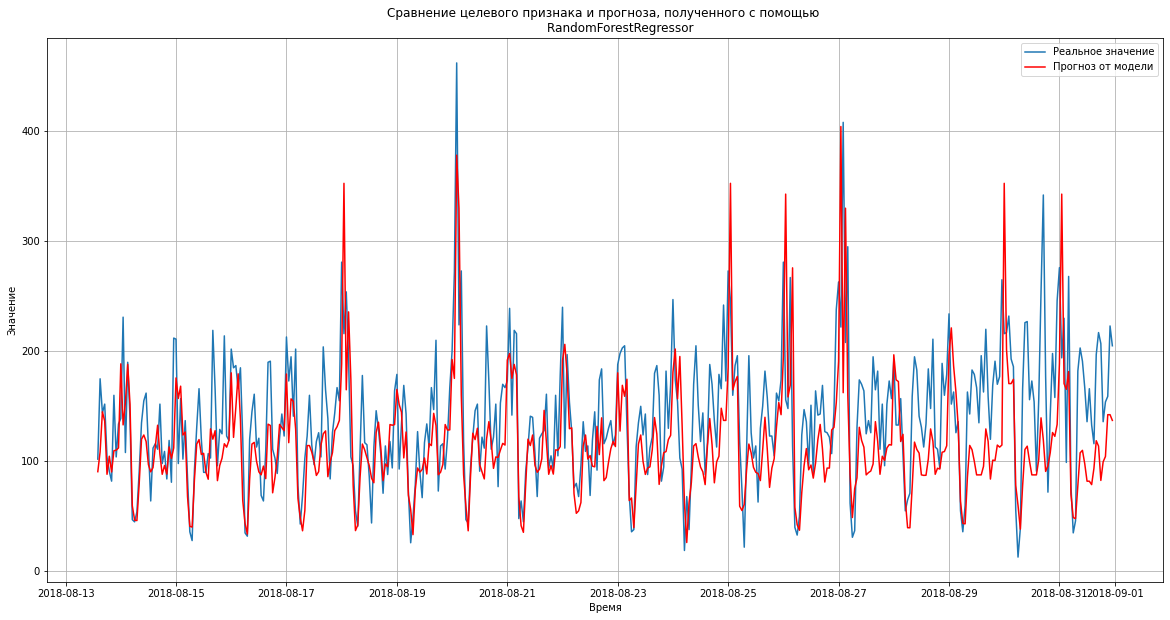

In [48]:
test.res(test.rf_model())

**Прогнозирование с помощью CatBoostRegressor**

Fitting 7 folds for each of 4 candidates, totalling 28 fits
0:	learn: 36.7988308	total: 18.6ms	remaining: 3.7s
10:	learn: 26.6215435	total: 191ms	remaining: 3.27s
20:	learn: 23.1348292	total: 354ms	remaining: 3.02s
30:	learn: 21.7640840	total: 514ms	remaining: 2.8s
40:	learn: 20.8971956	total: 673ms	remaining: 2.61s
50:	learn: 20.0196133	total: 864ms	remaining: 2.52s
60:	learn: 19.5024685	total: 1.03s	remaining: 2.35s
70:	learn: 18.8983778	total: 1.19s	remaining: 2.16s
80:	learn: 18.1477356	total: 1.35s	remaining: 1.98s
90:	learn: 17.7563177	total: 1.49s	remaining: 1.78s
100:	learn: 17.3530490	total: 1.63s	remaining: 1.6s
110:	learn: 16.8839615	total: 1.81s	remaining: 1.45s
120:	learn: 16.3802166	total: 1.97s	remaining: 1.28s
130:	learn: 16.0187791	total: 2.14s	remaining: 1.13s
140:	learn: 15.4986305	total: 2.32s	remaining: 972ms
150:	learn: 15.0809633	total: 2.49s	remaining: 808ms
160:	learn: 14.7099958	total: 2.65s	remaining: 642ms
170:	learn: 14.3646566	total: 2.82s	remaining: 479ms

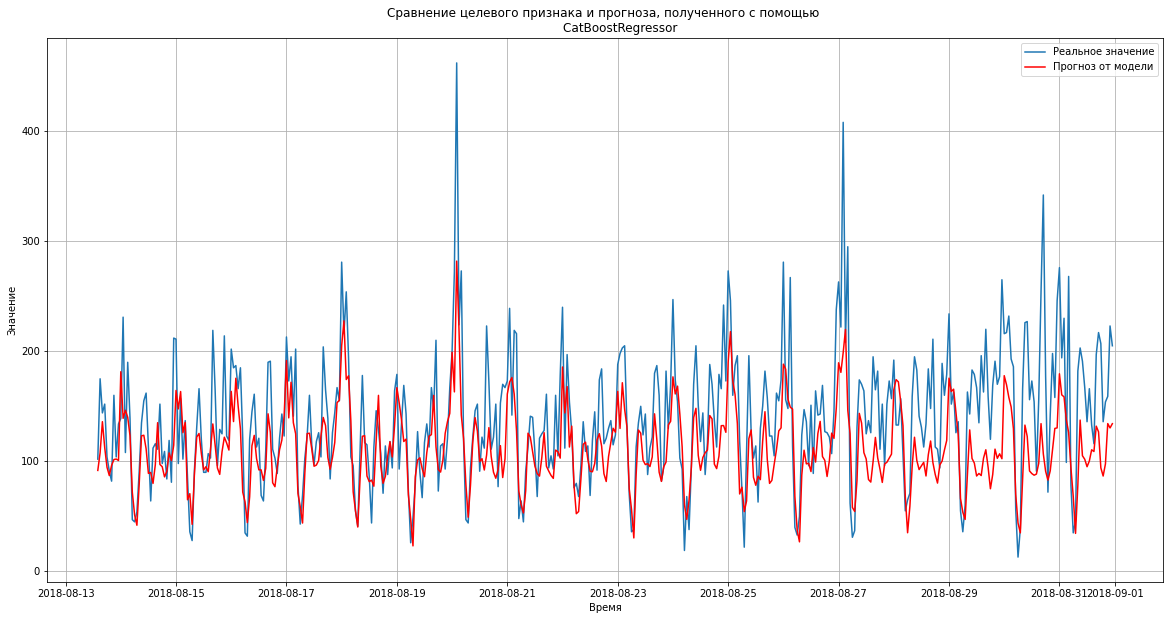

In [49]:
test.res(test.catboost())

**Прогнозирование с помощью LightGBMRegressor**

Fitting 7 folds for each of 64 candidates, totalling 448 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.026627
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000327 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 7
[LightGBM] [Info] Start training from score 78.498984
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trai

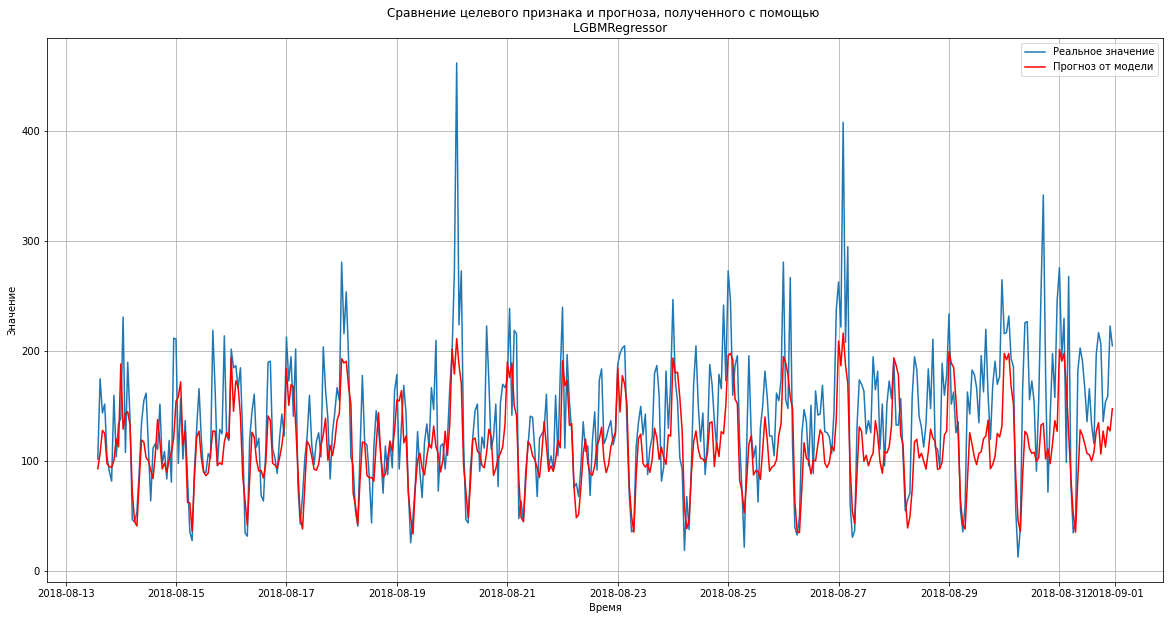

In [50]:
test.res(test.light_r())

Обобщим полученные результаты. Посмотрим на результаты финального тестирования:

In [51]:
test.print()

,Результаты финального тестирования
Константное значение,84.593643
Предыдущее значение,58.856486
LinearRegression,50.852933
DecisionTreeRegressor,54.147291
RandomForestRegressor,52.739917
CatBoostRegressor,49.578095
LGBMRegressor,46.994523


## Вывод 
 В результате получили следующие результаты: 

* Самая лучшая модель по метрике качества RMSE оказалась модель `LGBMRegressor`. Значение метрики RMSE при финальном тестировании составляет 40.9, что удовлетворяет условию заказчика (значение метрики не больше 48);
* Худшее значение метрики имеет модель `DecisionTreeRegressor`. При финальном тестировании получили значение, равное 58.5 (не удовлетворяет условию заказчика);
*  Все модели прошли проверку на адекватность, так как полученные значения метрики разных моделей меньше на простых простых прогнозов на основании предсказания единственным значением и предыдущим значением


## Общий вывод

Была дана задача:

> Нужно спрогнозировать количество заказов такси на следующий час. А также построить модель для такого предсказания.

Ключевым критерием для заказчика является следующее условие: 
>Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Для выполнения задания были предоставлены исторические данные о заказах такси в аэропорт.

В процессе знакомства и анализа данных заметили: 

1. К лету среднее число заказов плавно растет;
2. Сезонность: ежедневно к утру заказов практически нет, однако ближе к ночи количество заказов растет;
3. Определили, что ряд стационарен

После того, как убедились в том, что полученный ряд стационарен и готов для прогнозирования приступили к обучению моделей. 

В процессе подготовки к моделированию предложили следующие варианты для решения задачи:
1. Прогнозирование без обучения:
    * все значения прогнозируются одним числом - константой (в нашем случае - среднее значение);
    * текущее значение предсказывается предыдущим значением.
2. Прогнозирование с обучением:
    * Линейная регрессия;
    * Дерево решений;
    * Случайный лес;
    * CatBoostRegressor;
    * LightGBMRegressor.

Для прогнозирования с обучением необходимо сформировать признаки:
* Год;
* Месяц;
* День;
* День недели;
* Час;
* Сформировать временные лаги;
* Добавить скользящее среднее.

В результате обучения получили следующие результаты:

* Самая лучшая модель по метрике качества RMSE оказалась модель `LGBMRegressor`. Значение метрики RMSE при финальном тестировании составляет 40.9, что удовлетворяет условию заказчика (значение метрики не больше 48);
* Худшее значение метрики имеет модель `DecisionTreeRegressor`. При финальном тестировании получили значение, равное 58.5 (не удовлетворяет условию заказчика);
*  Все модели прошли проверку на адекватность, так как полученные значения метрики разных моделей меньше на простых простых прогнозов на основании предсказания единственным значением и предыдущим значением.

Поэтому для решения задачи заказчика предлагается использовать модель `LGBMRegressor` с заранее сформированными признаками по временному ряду: сформировать временной лаг и добавить скользящее среднее.